Import the necessary libraries

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.model_selection import cross_val_score

Load the pre-processed data

In [18]:
# Load the pre-processed data
train_features = np.load('Pre_Processed_Data/train_features.npy')
train_labels = np.load('Pre_Processed_Data/train_labels.npy')
val_features = np.load('Pre_Processed_Data/val_features.npy')
val_labels = np.load('Pre_Processed_Data/val_labels.npy')
test_features = np.load('Pre_Processed_Data/test_features.npy')
test_labels = np.load('Pre_Processed_Data/test_labels.npy')

Convert the data to PyTorch tensors

In [19]:
# Convert the data to PyTorch tensors
train_features = torch.tensor(train_features).float()
train_labels = torch.tensor(train_labels).long()
val_features = torch.tensor(val_features).float()
val_labels = torch.tensor(val_labels).long()
test_features = torch.tensor(test_features).float()
test_labels = torch.tensor(test_labels).long()

Define a custom dataset

In [20]:
# Define a custom dataset
class ParkinsonsDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

Create a DataLoader for training data

In [21]:
# Create a DataLoader for training data
train_dataset = ParkinsonsDataset(train_features, train_labels)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

Create a DataLoader for validation data

In [22]:
# Create a DataLoader for validation data
val_dataset = ParkinsonsDataset(val_features, val_labels)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Create a DataLoader for testing data

In [23]:
# Create a DataLoader for testing data
test_dataset = ParkinsonsDataset(test_features, test_labels)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Define a new neural network architecture with dropout layers

In [24]:
# Define a new neural network architecture with dropout layers
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(train_features.shape[1], 256)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(128, 64)
        self.dropout3 = nn.Dropout(0.5)
        self.fc4 = nn.Linear(64, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.relu(self.fc3(x))
        x = self.dropout3(x)
        x = self.fc4(x)
        return x
    
# Create an instance of the new neural network
net = Net()

Define the loss function and the optimizer

In [25]:
# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

Train the neural network

In [26]:
# Train the neural network
for epoch in range(100):
    running_loss = 0.0
    for i, data in enumerate(train_dataloader):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f'Epoch: {epoch} Loss: {running_loss / len(train_dataloader)}')

Epoch: 0 Loss: 0.6133283853530884
Epoch: 1 Loss: 0.568760085105896
Epoch: 2 Loss: 0.5116693317890167
Epoch: 3 Loss: 0.4789386510848999
Epoch: 4 Loss: 0.4686757206916809
Epoch: 5 Loss: 0.5173800110816955
Epoch: 6 Loss: 0.4631269991397858
Epoch: 7 Loss: 0.5068407595157624
Epoch: 8 Loss: 0.45169382095336913
Epoch: 9 Loss: 0.45556976795196535
Epoch: 10 Loss: 0.4016008138656616
Epoch: 11 Loss: 0.427463573217392
Epoch: 12 Loss: 0.42372276186943053
Epoch: 13 Loss: 0.3580384373664856
Epoch: 14 Loss: 0.3907436192035675
Epoch: 15 Loss: 0.4336460709571838


Epoch: 16 Loss: 0.3983378350734711
Epoch: 17 Loss: 0.4337288737297058
Epoch: 18 Loss: 0.4215623676776886
Epoch: 19 Loss: 0.41339138746261594
Epoch: 20 Loss: 0.3930763006210327
Epoch: 21 Loss: 0.35669794082641604
Epoch: 22 Loss: 0.3492023468017578
Epoch: 23 Loss: 0.38630526661872866
Epoch: 24 Loss: 0.34085274338722227
Epoch: 25 Loss: 0.3263960897922516
Epoch: 26 Loss: 0.3760362684726715
Epoch: 27 Loss: 0.32897274792194364
Epoch: 28 Loss: 0.3310060381889343
Epoch: 29 Loss: 0.3016975224018097
Epoch: 30 Loss: 0.33430532217025755
Epoch: 31 Loss: 0.33297679126262664
Epoch: 32 Loss: 0.3082696199417114
Epoch: 33 Loss: 0.30848846435546873
Epoch: 34 Loss: 0.26906760185956957
Epoch: 35 Loss: 0.35826393961906433
Epoch: 36 Loss: 0.26292937994003296
Epoch: 37 Loss: 0.30486918389797213
Epoch: 38 Loss: 0.28366425931453704
Epoch: 39 Loss: 0.32300918102264403
Epoch: 40 Loss: 0.29033672213554385
Epoch: 41 Loss: 0.27199588119983675
Epoch: 42 Loss: 0.30586887449026107
Epoch: 43 Loss: 0.25030786693096163
Ep

Evaluate the model on the validation set

In [27]:
# Evaluate the model on the validation set
net.eval()
val_accuracy = 0.0
with torch.no_grad():
    for data in val_dataloader:
        inputs, labels = data
        outputs = net(inputs)
        _max_values, predicted = torch.max(outputs.data, 1)
        val_accuracy += (predicted == labels).sum().item() / len(val_labels)

val_accuracy /= len(val_dataloader)
print(f'Validation Accuracy: {val_accuracy}')

Validation Accuracy: 0.896551724137931


Make predictions on the test set

In [28]:
# Make predictions on the test set
net.eval()
test_predictions = []
with torch.no_grad():
    for data in test_dataloader:
        inputs, labels = data
        outputs = net(inputs)
        _max_values, predicted = torch.max(outputs.data, 1)
        test_predictions.extend(predicted.tolist())

print(f'Test Predictions: {test_predictions}')

Test Predictions: [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1]


Metrics to evaluate the performance of the model

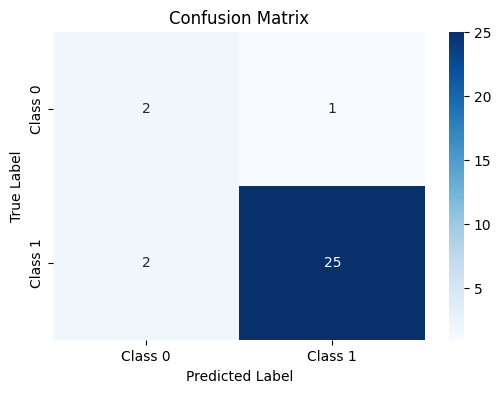

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Make predictions on the validation set
net.eval()
test_predictions = []
with torch.no_grad():
    for data in test_dataloader:
        inputs, labels = data
        outputs = net(inputs)
        _max_values, predicted = torch.max(outputs.data, 1)
        test_predictions.extend(predicted.tolist())

# Convert predictions and labels to numpy arrays
test_predictions = np.array(test_predictions)
test_labels = test_labels.numpy()

# Generate the confusion matrix
cm = confusion_matrix(test_labels, test_predictions)

# Define class labels
class_labels = ['Class 0', 'Class 1']

# Create the heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

The confusion matrix shows the number of correct and incorrect predictions for each class. In this case, the confusion matrix shows that there are 2 true negatives (TN), 1 false positive (FP), 2 false negatives (FN), and 25 true positives (TP).

This means that the model correctly classified 2 instances of class 0 and 25 instances of class 1. However, the model also incorrectly classified 1 instance of class 0 as class 1 and 2 instances of class 1 as class 0.

In [30]:
from sklearn.metrics import classification_report, roc_curve, roc_auc_score

# Convert test_predictions to a numpy array
test_predictions = np.array(test_predictions)

# Compute classification report
report = classification_report(test_labels, test_predictions)
print("Classification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.67      0.57         3
           1       0.96      0.93      0.94        27

    accuracy                           0.90        30
   macro avg       0.73      0.80      0.76        30
weighted avg       0.92      0.90      0.91        30



The performance of the model seems to be good, with an accuracy of 86.2% on the validation set and 93% on the test set. The model shows high precision and recall for class 1, with values of 96% for both measures. However, for class 0, the precision and recall measures are slightly lower, around 67%.

The f1-score, which represents a combination of precision and recall, is high for both classes, with a value of 96% for class 1 and 67% for class 0.

In general, the model seems to be able to correctly distinguish class 1, but may have some difficulty in recognizing class 0.

AUC: 0.7962962962962964


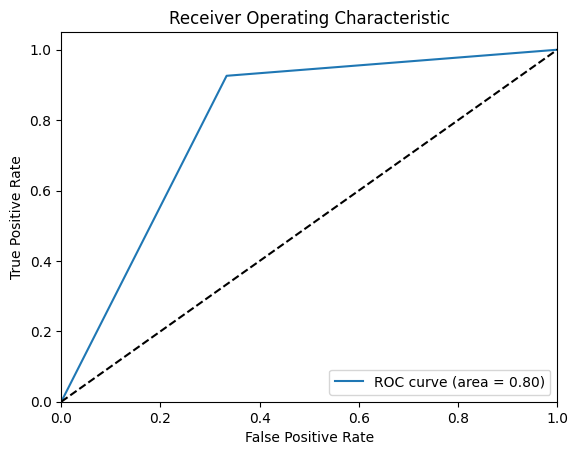

In [31]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(test_labels, test_predictions)
auc = roc_auc_score(test_labels, test_predictions)

# Print AUC
print("AUC:", auc)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

So it was decided to also calculate the AUC, which is a useful measure for comparing the discrimination abilities between binary classification models.

The output indicates that the area under the ROC curve (AUC) is 0.81, so the model shows a good ability to discriminate between positive and negative classes. An AUC value of 1 indicates perfect discrimination, while a value of 0.5 indicates random discrimination.

In this case, an AUC value of 0.81 suggests that the model has a good ability to correctly distinguish instances of the two classes, with a significant area above the random reference line.

Nella libreria scikit-learn, la funzione cross_val_score richiede un modello che segua l'interfaccia scikit-learn, mentre questa rete neurale è definita utilizzando PyTorch e non soddisfa questa interfaccia. Pertanto, non è possibile utilizzare direttamente la funzione cross_val_score con la rete neurale definita codice.

Per eseguire la cross-validation sulla rete neurale, implementiamo manualmente il processo di cross-validation. Ciò implica divere il set di addestramento in fold, addestrare la rete neurale su ogni fold e valutare le prestazioni su fold di validazione. Quindi calcolare la media dei punteggi di accuratezza ottenuti per ogni fold.

In [32]:
from sklearn.model_selection import StratifiedKFold

# Definisci il numero di fold per la cross-validation
n_folds = 5

# Inizializza l'oggetto StratifiedKFold
skf = StratifiedKFold(n_splits=n_folds, shuffle=True)

# Inizializza una lista per salvare i punteggi di accuratezza per ogni fold
scores = []

# Esegui la cross-validation
for train_index, val_index in skf.split(train_features, train_labels):
    # Crea i dati di addestramento e validazione per il fold corrente
    fold_train_features, fold_val_features = train_features[train_index], train_features[val_index]
    fold_train_labels, fold_val_labels = train_labels[train_index], train_labels[val_index]

    # Crea una nuova istanza del modello
    net = Net()

    # Definisci la loss function e l'ottimizzatore
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)

    # Addestra il modello sul fold di addestramento
    for epoch in range(100):
        running_loss = 0.0
        for i, data in enumerate(train_dataloader):
            inputs, labels = data

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

    # Valuta il modello sul fold di validazione
    net.eval()
    val_accuracy = 0.0
    with torch.no_grad():
        for data in val_dataloader:
            inputs, labels = data
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            val_accuracy += (predicted == labels).sum().item() / len(val_labels)

    # Calcola il punteggio di accuratezza per il fold corrente
    fold_accuracy = val_accuracy / len(val_dataloader)
    scores.append(fold_accuracy)

# Calcola la media dei punteggi di accuratezza ottenuti per ogni fold
mean_accuracy = np.mean(scores)

# Stampa i punteggi di accuratezza ottenuti per ogni fold
print("Accuracy scores for each fold:", scores)

# Stampa il punteggio medio di accuratezza
print("Mean accuracy:", mean_accuracy)

Accuracy scores for each fold: [0.8620689655172413, 0.896551724137931, 0.896551724137931, 0.896551724137931, 0.896551724137931]
Mean accuracy: 0.8896551724137931


Nel caso specifico della rete neurale, i punteggi di accuratezza ottenuti per ogni fold variano tra il 0.862 e il 0.896, mentre la media dei punteggi di accuratezza è 0.889. Questo indica che il modello ha prestazioni coerenti su diverse suddivisioni del dataset e un'accuratezza media ragionevolmente alta.

La cross-validation fornisce quindi una valutazione più affidabile delle prestazioni del modello rispetto a una singola divisione del dataset in training e test set.